# Installation
Full installation instructions can be found [here](https://github.com/dafyddstephenson/C-Star/tree/python_package/cstar_ocean/README.md) (`README.md` in the parent directory)


In [1]:
import os
import cstar

# Introduction to C-Star "v0" with the `roms_marbl_example` Case

In this notebook we will take a look at the `roms_marbl_example` C-Star case. We can instantiate a C-Star case either from a blueprint (`.yaml` file) or by manually setting it up. Here we'll build a C-Star case from scratch to demonstrate the various structures in C-Star, then we can export the Case to a blueprint-style YAML file to be shared or re-used.


## Overview of C-Star structures
- A `Case` (`cstar.Case`) is the primary object of C-Star. It contains all the necessary information for a user to run a reproducable Earth system simulation. A Case is built from Components (`cstar.base.Component`), each representing a specific configuration of a model of one part of the overall system being simulated. In this notebook we'll be working with an ocean circulation component and a biogeochemistry component.
    - **The `Component` object** itself consists of, at least, a base model (`cstar.base.BaseModel`), and optionally additional code (`cstar.base.AdditionalCode`), input datasets (`cstar.base.InputDataset`), and discretization information (`cstar.base.Discretization`) needed to run the base model in the specific configuration in question. 
        - **A `BaseModel` object** describes the "off-the-shelf" model underlying a Component. It does not contain any information relative to the specific domain, forcing, code modifications, or combination of parameters with which the model will be run in our particular use case. Typically it will simply point (using the `source_repo` attribute) to the repository in which a development team hosts a model (in this case the ROMS and MARBL source code repositories), and features a `checkout_target` attribute instructing C-Star on which version of this source code to use.
        - **An `AdditionalCode` object** also describes code associated with the base model, this time containing code that is necessary to run the base model _in a particular configuration_ of interest. This may include runtime namelist files specifying parameter values and paths to input data, or compile-time option files or source-code modifications. This is effectively code that would not normally be included with a model, but may be required in order to run it. 
        - **An `InputDataset` object** is a descriptor of any non-plaintext file needed to run our base model in a particular configuration. These are typically netCDF files describing the domain, initial conditions, surface and boundary forcing of a particular simulation we'd like to run using the base model.
        - **A `Discretization` object** contains any information related to the discretization of a Component, such as time step and CPU distribution.

- You can find more information on C-Star `Case`, `Component`, `BaseModel`, `AdditionalCode`, and `InputDataset` objects by querying, e.g., `cstar.base.Component?` in a cell.

## The structure of the Case:
The `roms_marbl_example` case structure breaks down like this:  
```
Case
├── MARBLComponent
│   └── base_model (MARBLBaseModel)
└── ROMSComponent
    ├── base_model (ROMSBaseModel)
    ├── namelists (AdditionalCode)
    ├── additional_source_code (AdditionalCode)
    ├── model_grid (ROMSInputDataset)
    ├── initial_conditions (ROMSInputDataset)
    ├── tidal_forcing (ROMSInputDataset)
    ├── surface_forcing (list of ROMSInputDatasets)
    ├── boundary_forcing (list of ROMSInputDatasets)
    └── discretization (ROMSDiscretization)

```
You will notice that the `Component`, `BaseModel`, `InputDataset`, and `Discretization` objects here are specific to the object they describe (e.g. `ROMSBaseModel`). This is because there may be some unique attributes or operations associated with the `BaseModel` object describing ROMS that may be different to that describing MARBL, which has its own subclass `MARBLBaseModel`.

To build this case from the bottom up, we'll need to first build `BaseModel` objects for ROMS and MARBL

## Constructing the BaseModel objects
To initialize a `BaseModel` object (see `cstar.base.BaseModel?`), we need a `source_repo` (repository URL containing the base model source code) and a `checkout_target` (a point in the repository history we'd like to jump to). For ROMS we'll use the latest commit hash. For MARBL we'll use v0.45, around which the ROMS-MARBL driver was built:

In [2]:
from cstar.roms import ROMSBaseModel
from cstar.marbl import MARBLBaseModel

In [3]:
roms_base_model = ROMSBaseModel(
    source_repo='https://github.com/CESR-lab/ucla-roms.git',
    checkout_target='246c11fa537145ba5868f2256dfb4964aeb09a25',
)

marbl_base_model = MARBLBaseModel(
    source_repo='https://github.com/marbl-ecosys/MARBL.git',
    checkout_target='marbl0.45.0',
)

In [4]:
print(roms_base_model)

ROMSBaseModel
-------------
source_repo : https://github.com/CESR-lab/ucla-roms.git (default)
checkout_target : 246c11fa537145ba5868f2256dfb4964aeb09a25
local_config_status: 0 (Environment variable ROMS_ROOT is present, points to the correct repository remote, and is checked out at the correct hash)


In [5]:
print(marbl_base_model)

MARBLBaseModel
--------------
source_repo : https://github.com/marbl-ecosys/MARBL.git (default)
checkout_target : marbl0.45.0 (corresponding to hash 6e6b2f7c32ac5427e6cf46de4222973b8bcaa3d9)
local_config_status: 0 (Environment variable MARBL_ROOT is present, points to the correct repository remote, and is checked out at the correct hash)


## Constructing the AdditionalCode objects

To construct an `AdditionalCode` object, we need a `location` pointing to a local or remote directory or repository.
In this example, we will use a remote repository, so we also supply a `subdir` (relative to the repository top level) and `checkout_target` argument to initialise the `AdditionalCode` instance.
We also need to provide a list of files pointing to our `AdditionalCode`.

In this example we are using MARBL and ROMS. As ROMS handles all input and output to MARBL, we only need `AdditionalCode` instances for ROMS: one for run-time files (namelists) and the other for compile-time files (such as ROMS' `.opt` files, which are used to set model parameters)

In [6]:
from cstar.base import AdditionalCode

In [7]:
roms_namelists = AdditionalCode(
    location = "https://github.com/CWorthy-ocean/cstar_blueprint_roms_marbl_example.git",
    subdir = "additional_code/ROMS/namelists",
    checkout_target = "a9762a46a36c09225423305a1aaa59bdeb984074",
    files = [
        "roms.in_TEMPLATE",
        "marbl_in",
        "marbl_tracer_output_list",
        "marbl_diagnostic_output_list"
    ]
)
print(roms_namelists)

AdditionalCode
--------------
Location: https://github.com/CWorthy-ocean/cstar_blueprint_roms_marbl_example.git
subdirectory: additional_code/ROMS/namelists
Working path: None
Exists locally: False (get with AdditionalCode.get())
Files:
    roms.in_TEMPLATE      (roms.in will be used by C-Star based on this template)
    marbl_in
    marbl_tracer_output_list
    marbl_diagnostic_output_list


In [8]:
roms_additional_source_code = AdditionalCode(
    location = "https://github.com/CWorthy-ocean/cstar_blueprint_roms_marbl_example.git",
    subdir = "additional_code/ROMS/source_mods",
    checkout_target = "a9762a46a36c09225423305a1aaa59bdeb984074",
    files = [
        "bgc.opt",
         "bulk_frc.opt",
         "cppdefs.opt",
         "diagnostics.opt",
         "ocean_vars.opt",
         "param.opt",
         "tracers.opt",
         "Makefile",
         "Make.depend",
    ]
)

print(roms_additional_source_code)

AdditionalCode
--------------
Location: https://github.com/CWorthy-ocean/cstar_blueprint_roms_marbl_example.git
subdirectory: additional_code/ROMS/source_mods
Working path: None
Exists locally: False (get with AdditionalCode.get())
Files:
    bgc.opt
    bulk_frc.opt
    cppdefs.opt
    diagnostics.opt
    ocean_vars.opt
    param.opt
    tracers.opt
    Makefile
    Make.depend


---

Note that for `roms_namelists`, in the first entry under `files`, the namelist file we begin with is a template. C-Star recognises the `_TEMPLATE` suffix and works with a local copy (in this case `roms.in`) that it will modify and use to run ROMS with user choices such as run length)

## Constructing the InputDataset objects
To run this case, we need different types of input dataset, each with a specialized subclass of the `InputDataset` class:
- a grid file supplying information about the domain to ROMS (`ROMSModelGrid`)
- An initial condition file from which to start the run (`ROMSInitialConditions`)
- boundary forcing files providing information at the edge of the domain (`ROMSBoundaryConditions`)
- surface forcing files providing information at the upper boundary (`ROMSSurfaceForcing`)
- tidal forcing files providing information on tidal constituents (`ROMSTidalForcing`)

To construct an `InputDataset` object, we need (see `cstar.InputDataset?`):
- a `location` : either a path or URL, pointing to this file.
- a `file_hash` : as our location is a URL in this example, we also need a [SHA256 checksum](https://en.wikipedia.org/wiki/Checksum) to verify any downloads

In our case, all the files associated with our `roms_marbl_example` case are small and [fit in a repository](https://github.com/CWorthy-ocean/input_datasets_roms_marbl_example). 

In [9]:
from cstar.roms import ROMSModelGrid, ROMSInitialConditions, ROMSTidalForcing, ROMSBoundaryForcing, ROMSSurfaceForcing

In [10]:
#Grid
roms_model_grid = ROMSModelGrid(
    location="https://github.com/CWorthy-ocean/input_datasets_roms_marbl_example/raw/main/roms_grd.nc",
    file_hash="fd537ef8159fabb18e38495ec8d44e2fa1b7fb615fcb1417dd4c0e1bb5f4e41d",
)
# Initial conditions
roms_initial_conditions = ROMSInitialConditions(
    location="https://github.com/CWorthy-ocean/input_datasets_roms_marbl_example/raw/main/MARBL_rst.20120103120000.nc",
    file_hash="fc3bbd039256edc89c898efda0eebc5c53773995598d59310bc6d57f454a6ddd",
)
# Tides
roms_tidal_forcing = ROMSTidalForcing(
    location="https://github.com/CWorthy-ocean/input_datasets_roms_marbl_example/raw/main/roms_tides.nc",
    file_hash="90db174ab174909f9bf27c13fa19995c03f680bcb80e7d012268505b48590338",
)
# Boundary
roms_phys_boundary_forcing = ROMSBoundaryForcing(
    location="https://github.com/CWorthy-ocean/input_datasets_roms_marbl_example/raw/main/roms_bry_2012.nc",
    file_hash="c3b0e14aae6dd5a0d54703fa04cf95960c1970e732c0a230427bf8b0fbbd8bf1",
)
roms_bgc_boundary_forcing = ROMSBoundaryForcing(
    location = "https://github.com/CWorthy-ocean/input_datasets_roms_marbl_example/raw/main/roms_bry_bgc_MARBL.nc",
    file_hash = "897a8df8ed45841a98b3906f2dd07750decc5c2b50095ba648a855c869c7d3ee",
)
# Surface
roms_bgc_surface_forcing = ROMSSurfaceForcing(
    location="https://github.com/CWorthy-ocean/input_datasets_roms_marbl_example/raw/main/roms_frc_bgc.nc",
    file_hash="621dd23691d87aa93c5cc582daf6c5f18333ed062ff934777d50b63346c3f84d",
)
roms_phys_surface_forcing = ROMSSurfaceForcing(
    location="https://github.com/CWorthy-ocean/input_datasets_roms_marbl_example/raw/main/roms_frc.201201.nc",
    file_hash="923049a9c2ab9ce77fa4a0211585e6848a12e87bf237e7aa310f693c3ac6abfa",
)


We can query each input dataset to get pertinent information about its state, e.g.:

In [11]:
print(roms_phys_boundary_forcing)

-------------------
ROMSBoundaryForcing
-------------------
Source location: https://github.com/CWorthy-ocean/input_datasets_roms_marbl_example/raw/main/roms_bry_2012.nc
file_hash: c3b0e14aae6dd5a0d54703fa04cf95960c1970e732c0a230427bf8b0fbbd8bf1
Working path: None ( does not yet exist. Call InputDataset.get() )


## Constructing the Discretization object
Lastly, we need to tell C-Star how we will be discretizing our components. MARBL piggybacks off the discretization of its host model, so we only need to create a `ROMSDiscretization` object. This contains:
- the time step (`time_step` , in seconds)
- the number of processors following x and y for running in parallel (`n_procs_x`, `n_procs_y`)

In [12]:
from cstar.roms import ROMSDiscretization

roms_discretization = ROMSDiscretization(time_step = 360,
                                         n_procs_x = 3,
                                         n_procs_y = 3)
print(roms_discretization)

ROMSDiscretization
------------------
time_step: 360s
n_procs_x: 3 (Number of x-direction processors)
n_procs_y: 3 (Number of y-direction processors)


## Putting it all together to build ROMS and MARBL components:
We now have everything we need to create the `MARBLComponent` and `ROMSComponent` objects that come together to make our Case.

In [13]:
from cstar.roms import ROMSComponent
from cstar.marbl import MARBLComponent

### MARBL:

In [14]:
marbl_component = MARBLComponent(
    base_model = marbl_base_model
)
print(marbl_component)

MARBLComponent
--------------
base_model: MARBLBaseModel instance (query using Component.base_model)


### ROMS
a ROMSComponent object (see `cstar.ROMSComponent?`) is a little more involved, not just because there are more objects going into it. Because we will be running this ROMS simulation in parallel, we should also supply information about how to distribute the domain among CPUs:

In [15]:
roms_component = ROMSComponent(
    base_model = roms_base_model,
    namelists = roms_namelists,
    additional_source_code = roms_additional_source_code,
    discretization = roms_discretization,
    model_grid = roms_model_grid,
    initial_conditions = roms_initial_conditions,
    tidal_forcing = roms_tidal_forcing,
    boundary_forcing = [roms_phys_boundary_forcing,roms_bgc_boundary_forcing],
    surface_forcing = [roms_phys_surface_forcing, roms_bgc_surface_forcing]
)
print(roms_component)

ROMSComponent
-------------
base_model: ROMSBaseModel instance (query using Component.base_model)
additional_source_code: AdditionalCode instance with 9 files (query using Component.additional_source_code)
namelists: AdditionalCode instance with 4 files (query using Component.namelists)
model_grid = <ROMSModelGrid instance>
initial_conditions = <ROMSInitialConditions instance>
tidal_forcing = <ROMSTidalForcing instance>
surface_forcing = <list of 2 ROMSSurfaceForcing instances>
boundary_forcing = <list of 2 ROMSBoundaryForcing instances>

Discretization:
ROMSDiscretization
------------------
time_step: 360s
n_procs_x: 3 (Number of x-direction processors)
n_procs_y: 3 (Number of y-direction processors)


## And finally, we can build the Case object:
This is instantiated using a list of components, a name string, and a "caseroot" - the local path where the case will be run. Additionally we choose a start date and end date for the run. The values below run the case for one model month, which may take several minutes to run (depending on your machine). **If you'd like to run the case more quickly**, modify `end_date` below:

In [16]:
from cstar import Case

In [17]:
roms_marbl_case = Case(
    components=[roms_component, marbl_component],
    name='roms_marbl_example_cstar_case',
    caseroot=os.getcwd() + '/roms_marbl_example_cstar_case',
    start_date='20120103 12:00:00',
    end_date='20120131 12:00:00',
)
print(roms_marbl_case)

C-Star Case
-----------
Name: roms_marbl_example_cstar_case
caseroot: /Users/dafyddstephenson/Code/my_c_star/examples/roms_marbl_example_cstar_case
start_date: 2012-01-03 12:00:00
end_date: 2012-01-31 12:00:00
Is setup: False
Valid date range:
valid_start_date: None
valid_end_date: None

It is built from the following Components (query using Case.components): 
   <ROMSComponent instance>
   <MARBLComponent instance>


/Users/dafyddstephenson/Code/my_c_star/cstar/case.py:103: RuntimeWarning: Valid start date not provided. Unable to check if simulation dates are out of range. Case objects should be initialized with valid_start_date and valid_end_date attributes.
  warnings.warn(
/Users/dafyddstephenson/Code/my_c_star/cstar/case.py:119: RuntimeWarning: Valid end date not provided. Unable to check if simulation dates are out of range. Case objects should be initialized with valid_start_date and valid_end_date attributes.
  warnings.warn(


## Visualizing the Case:
We can see how the caseroot directory will look once the case is set up using `Case.tree()`:

In [18]:
roms_marbl_case.tree()

/Users/dafyddstephenson/Code/my_c_star/examples/roms_marbl_example_cstar_case
├── input_datasets
│   └── ROMS
│       ├── roms_grd.nc
│       ├── MARBL_rst.20120103120000.nc
│       ├── roms_tides.nc
│       ├── roms_bry_2012.nc
│       ├── roms_bry_bgc_MARBL.nc
│       ├── roms_frc.201201.nc
│       └── roms_frc_bgc.nc
├── namelists
│   └── ROMS
│       ├── roms.in_TEMPLATE
│       ├── marbl_in
│       ├── marbl_tracer_output_list
│       └── marbl_diagnostic_output_list
└── additional_source_code
    └── ROMS
        ├── bgc.opt
        ├── bulk_frc.opt
        ├── cppdefs.opt
        ├── diagnostics.opt
        ├── ocean_vars.opt
        ├── param.opt
        ├── tracers.opt
        ├── Makefile
        └── Make.depend



## Setting the Case up
We can see from querying the `roms_marbl_case` object above (`Is setup: False`) that the case has not yet been set up locally. 

To set the case up, we run `roms_marbl_case.setup()`, which performs a series of actions:
- check the base model has been installed and, if not, ask the user if they would like to:
  - download ROMS and compile its dependencies
  - download and compile MARBL
- retrieve any additional code using `AdditionalCode.get()`
- retrieve any input datasets using `InputDataset.get()`

When the base models are installed, a file `cstar_local_config.py` will be created (or appended to) defining the user's environment such that these base models are available on your machine next time you import C-Star.

In [19]:
roms_marbl_case.setup()


Setting up ROMSComponent
-------------------------
Configuring ROMSComponent
-------------------------
ROMSBaseModel correctly configured. Nothing to be done

Fetching additional source code...
----------------------------------
Cloned repository https://github.com/CWorthy-ocean/cstar_blueprint_roms_marbl_example.git to /var/folders/1s/xjsjyqrj2rdft8014664qczc0000gn/T/tmpjqpchuel
Checked out a9762a46a36c09225423305a1aaa59bdeb984074 in git repository /var/folders/1s/xjsjyqrj2rdft8014664qczc0000gn/T/tmpjqpchuel
copying bgc.opt to /Users/dafyddstephenson/Code/my_c_star/examples/roms_marbl_example_cstar_case/additional_source_code/ROMS
copying bulk_frc.opt to /Users/dafyddstephenson/Code/my_c_star/examples/roms_marbl_example_cstar_case/additional_source_code/ROMS
copying cppdefs.opt to /Users/dafyddstephenson/Code/my_c_star/examples/roms_marbl_example_cstar_case/additional_source_code/ROMS
copying diagnostics.opt to /Users/dafyddstephenson/Code/my_c_star/examples/roms_marbl_example_cstar_

Cloned repository https://github.com/CWorthy-ocean/cstar_blueprint_roms_marbl_example.git to /var/folders/1s/xjsjyqrj2rdft8014664qczc0000gn/T/tmpu244_sq0
Checked out a9762a46a36c09225423305a1aaa59bdeb984074 in git repository /var/folders/1s/xjsjyqrj2rdft8014664qczc0000gn/T/tmpu244_sq0
copying roms.in_TEMPLATE to /Users/dafyddstephenson/Code/my_c_star/examples/roms_marbl_example_cstar_case/namelists/ROMS
copying template file /Users/dafyddstephenson/Code/my_c_star/examples/roms_marbl_example_cstar_case/namelists/ROMS/roms.in_TEMPLATE to editable version /Users/dafyddstephenson/Code/my_c_star/examples/roms_marbl_example_cstar_case/namelists/ROMS/roms.in
copying marbl_in to /Users/dafyddstephenson/Code/my_c_star/examples/roms_marbl_example_cstar_case/namelists/ROMS
copying marbl_tracer_output_list to /Users/dafyddstephenson/Code/my_c_star/examples/roms_marbl_example_cstar_case/namelists/ROMS
copying marbl_diagnostic_output_list to /Users/dafyddstephenson/Code/my_c_star/examples/roms_marbl


Setting up MARBLComponent
--------------------------
Configuring MARBLComponent
--------------------------
MARBLBaseModel correctly configured. Nothing to be done


## Saving the Case to a YAML file
We can save all the information associated with this case to a YAML file using `Case.persist(filename)`
If we want to run this exact Case again, we can use the `Case.from_blueprint(filename)` method:

In [20]:
roms_marbl_case.persist(roms_marbl_case.caseroot / 'roms_marbl_case.yaml')

In [21]:
print((roms_marbl_case.caseroot/"roms_marbl_case.yaml").read_text())

registry_attrs:
  name: roms_marbl_example_cstar_case
components:
- component:
    component_type: ROMS
    base_model:
      source_repo: https://github.com/CESR-lab/ucla-roms.git
      checkout_target: 246c11fa537145ba5868f2256dfb4964aeb09a25
    additional_source_code:
      location: https://github.com/CWorthy-ocean/cstar_blueprint_roms_marbl_example.git
      subdir: additional_code/ROMS/source_mods
      checkout_target: a9762a46a36c09225423305a1aaa59bdeb984074
      files:
      - bgc.opt
      - bulk_frc.opt
      - cppdefs.opt
      - diagnostics.opt
      - ocean_vars.opt
      - param.opt
      - tracers.opt
      - Makefile
      - Make.depend
    namelists:
      location: https://github.com/CWorthy-ocean/cstar_blueprint_roms_marbl_example.git
      subdir: additional_code/ROMS/namelists
      checkout_target: a9762a46a36c09225423305a1aaa59bdeb984074
      files:
      - roms.in_TEMPLATE
      - marbl_in
      - marbl_tracer_output_list
      - marbl_diagnostic_output_list

## Compiling the Case
Now we have all of the necessary code and data to run the case, we can compile it using `roms_marbl_case.build()`

In [22]:
roms_marbl_case.build()


Compiling ROMSComponent
------------------------
Compiling UCLA-ROMS configuration...
UCLA-ROMS compiled at /Users/dafyddstephenson/Code/my_c_star/examples/roms_marbl_example_cstar_case/additional_source_code/ROMS

Compiling MARBLComponent
-------------------------
No build steps to be completed for MARBLComponent


## Running the Case
There are three stages to this:
- `roms_marbl_case.pre_run()` performs pre-processing steps such as partitioning input datasets and modifying namelists to set runtime parameters used by the model (such as the time step)
- `roms_marbl_case.run()` calls the executable that we created with `roms_marbl_case.build()`
- `roms_marbl_case.post_run()` performs post-processing steps such as joining output datasets (which are output in tiles, one per processor)

In [23]:
roms_marbl_case.pre_run()



Completing pre-processing steps for ROMSComponent
--------------------------------------------------
Partitioning /Users/dafyddstephenson/Code/my_c_star/examples/roms_marbl_example_cstar_case/input_datasets/ROMS/roms_grd.nc into (3,3)
Partitioning /Users/dafyddstephenson/Code/my_c_star/examples/roms_marbl_example_cstar_case/input_datasets/ROMS/MARBL_rst.20120103120000.nc into (3,3)
Partitioning /Users/dafyddstephenson/Code/my_c_star/examples/roms_marbl_example_cstar_case/input_datasets/ROMS/roms_tides.nc into (3,3)
Partitioning /Users/dafyddstephenson/Code/my_c_star/examples/roms_marbl_example_cstar_case/input_datasets/ROMS/roms_bry_2012.nc into (3,3)
Partitioning /Users/dafyddstephenson/Code/my_c_star/examples/roms_marbl_example_cstar_case/input_datasets/ROMS/roms_bry_bgc_MARBL.nc into (3,3)
Partitioning /Users/dafyddstephenson/Code/my_c_star/examples/roms_marbl_example_cstar_case/input_datasets/ROMS/roms_frc.201201.nc into (3,3)
Partitioning /Users/dafyddstephenson/Code/my_c_star/ex

In [24]:
roms_marbl_case.run()


Running ROMS: 
------------
Running ROMS: Initializing run...
Running ROMS: time-step 135 of 6720 (16.3s elapsed; ETA 794.8s)
Running ROMS: time-step 270 of 6720 (32.6s elapsed; ETA 779.9s)
Running ROMS: time-step 405 of 6720 (49.0s elapsed; ETA 764.8s)
Running ROMS: time-step 540 of 6720 (65.6s elapsed; ETA 750.2s)
Running ROMS: time-step 675 of 6720 (81.9s elapsed; ETA 733.8s)
Running ROMS: time-step 810 of 6720 (98.3s elapsed; ETA 717.4s)
Running ROMS: time-step 945 of 6720 (114.6s elapsed; ETA 700.3s)
Running ROMS: time-step 1080 of 6720 (131.2s elapsed; ETA 685.1s)
Running ROMS: time-step 1215 of 6720 (147.5s elapsed; ETA 668.4s)
Running ROMS: time-step 1350 of 6720 (163.9s elapsed; ETA 652.0s)
Running ROMS: time-step 1485 of 6720 (180.3s elapsed; ETA 635.7s)
Running ROMS: time-step 1620 of 6720 (196.8s elapsed; ETA 619.6s)
Running ROMS: time-step 1755 of 6720 (213.2s elapsed; ETA 603.1s)
Running ROMS: time-step 1890 of 6720 (229.7s elapsed; ETA 587.1s)
Running ROMS: time-step 20

In [25]:
roms_marbl_case.post_run()



Completing post-processing steps for ROMSComponent
---------------------------------------------------
Joining netCDF files ROMS_MARBL_rst.20120117120000.*.nc...
Joining netCDF files ROMS_MARBL_rst.20120120120000.*.nc...
Joining netCDF files ROMS_MARBL_his.20120105120000.*.nc...
Joining netCDF files ROMS_MARBL_his.20120119120000.*.nc...
Joining netCDF files ROMS_MARBL_his.20120108120000.*.nc...
Joining netCDF files ROMS_MARBL_his.20120114120000.*.nc...
Joining netCDF files ROMS_MARBL_his.20120123120000.*.nc...
Joining netCDF files ROMS_MARBL_rst.20120131120000.*.nc...
Joining netCDF files ROMS_MARBL_rst.20120106120000.*.nc...
Joining netCDF files ROMS_MARBL_rst.20120128120000.*.nc...
Joining netCDF files ROMS_MARBL_his.20120126120000.*.nc...
Joining netCDF files ROMS_MARBL_his.20120111120000.*.nc...
Joining netCDF files ROMS_MARBL_rst.20120125120000.*.nc...
Joining netCDF files ROMS_MARBL_rst.20120112120000.*.nc...
Joining netCDF files ROMS_MARBL_rst.20120109120000.*.nc...
Joining net

## A quick look at the output
The output of the case consists of 4 file types:
- `ROMS_MARBL_bgc.20120103120000.nc` contains the 32 BGC tracers
- `ROMS_MARBL_bgc_dia.20120103120000.nc` contains 343 BGC diagnostics
- `ROMS_MARBL_his.201201??120000.nc` contains ocean physics variables
- `ROMS_MARBL_rst.201201??120000.nc` are restart files

In [26]:
ls {roms_marbl_case.caseroot}/output/

PARTITIONED/                          ROMS_MARBL_his.20120130120000.nc
ROMS_MARBL_bgc.20120103120000.nc      ROMS_MARBL_his.20120131120000.nc
ROMS_MARBL_bgc_dia.20120103120000.nc  ROMS_MARBL_rst.20120104120000.nc
ROMS_MARBL_his.20120103120000.nc      ROMS_MARBL_rst.20120105120000.nc
ROMS_MARBL_his.20120104120000.nc      ROMS_MARBL_rst.20120106120000.nc
ROMS_MARBL_his.20120105120000.nc      ROMS_MARBL_rst.20120107120000.nc
ROMS_MARBL_his.20120106120000.nc      ROMS_MARBL_rst.20120108120000.nc
ROMS_MARBL_his.20120107120000.nc      ROMS_MARBL_rst.20120109120000.nc
ROMS_MARBL_his.20120108120000.nc      ROMS_MARBL_rst.20120110120000.nc
ROMS_MARBL_his.20120109120000.nc      ROMS_MARBL_rst.20120111120000.nc
ROMS_MARBL_his.20120110120000.nc      ROMS_MARBL_rst.20120112120000.nc
ROMS_MARBL_his.20120111120000.nc      ROMS_MARBL_rst.20120113120000.nc
ROMS_MARBL_his.20120112120000.nc      ROMS_MARBL_rst.20120114120000.nc
ROMS_MARBL_his.20120113120000.nc      ROMS_MARBL_rst.20120115120000.nc
ROMS_M

In [26]:
import numpy as np
import xarray as xr

In [27]:
BGC_DS = xr.open_dataset(roms_marbl_case.caseroot + '/output/ROMS_MARBL_bgc.20120103120000.nc')
var = 'DOC'
BGC_DA = BGC_DS[var].isel(s_rho=99)

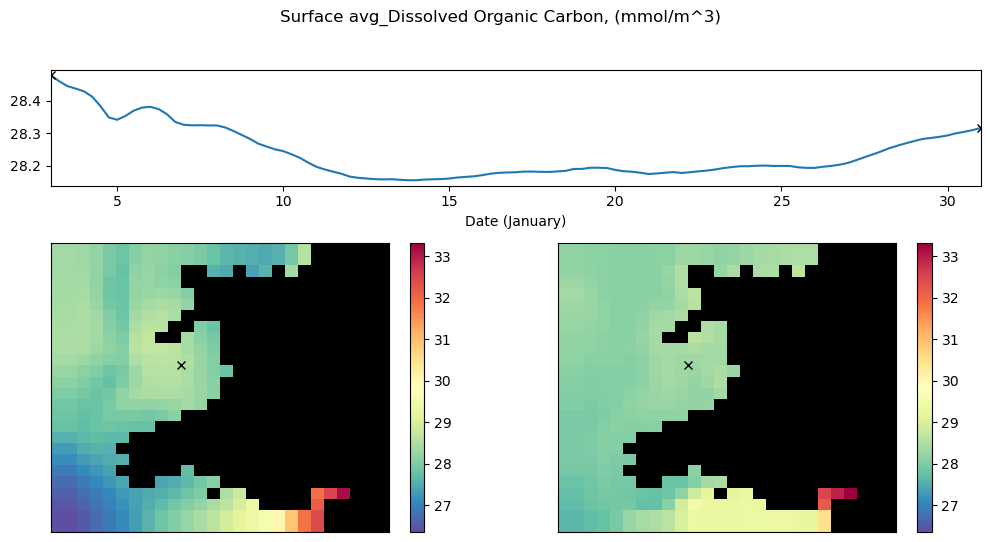

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

fig = plt.figure()
CMAP = plt.colormaps['Spectral_r'].__copy__()
CMAP.set_under('k')

gs = GridSpec(3, 2, figure=fig, hspace=0.5)
ax1 = fig.add_subplot(gs[0, :])

ax2 = fig.add_subplot(gs[1:, 0])
ax3 = fig.add_subplot(gs[1:, 1])

VMIN = np.min(BGC_DA.values[BGC_DA.values > 0])
VMAX = np.max(BGC_DA.values[BGC_DA.values > 0])

p2 = ax2.pcolormesh(BGC_DA.isel(time=0).values, vmin=VMIN, vmax=VMAX, cmap=CMAP)
p3 = ax3.pcolormesh(BGC_DA.isel(time=-1).values, vmin=VMIN, vmax=VMAX, cmap=CMAP)
[a.set_xticks([]) for a in [ax2, ax3]]
[a.set_yticks([]) for a in [ax2, ax3]]
ax2.plot(10, 15, 'kx')
ax3.plot(10, 15, 'kx')

ax1.plot(3 + BGC_DA.time * 3600 * 6 / 86400, BGC_DA[:,15,10])
ax1.set_xlim(3, 31)
ax1.set_xlabel('Date (January)')
#ax1.set_ylim(VMIN, VMAX)
ax1.plot(3 + BGC_DA.time[0] * 3600 * 6 / 86400, BGC_DA[0,15,10],'kx')
ax1.plot(3 + BGC_DA.time[-1] * 3600 * 6 / 86400, BGC_DA[-1,15,10],'kx')
fig.colorbar(p2, ax=ax2)
fig.colorbar(p3, ax=ax3)

fig.suptitle(f'Surface {BGC_DS[var].long_name}, ({BGC_DS[var].units})')
fig.set_size_inches(12,6)

The "X" in this plot highlights the point whose time series is plotted in the top panel. The lower left panel represents the first snapshot (January 3rd) and the lower right panel represents the final snapshot (January 31st)